In [1]:
using Knet,Compat,Interact,Plots;
include("../julia/format_data.jl");

In [66]:
# file, training_proportion, num_input_stops, stops_ahead_to_predict, stops_to_predict
routes = get_routes("../python/full_routes.mat",0.8,10,1,2);

x_train  = routes["train_input_data"];
y_train = routes["train_output_data"];
x_test = routes["test_input_data"];
y_test = routes["test_output_data"];



In [67]:
x_train = (x_train .- mean(x_train,2))./std(x_train,2);
x_test = (x_test .- mean(x_test,2))./std(x_test,2);
size(x_test),size(y_test)
size(x_train),size(y_train)

((10, 149), (2, 149))

In [68]:
function predict(w,x)
    for i=1:2:length(w)
        # w is a vector of weight matrices
        x = w[i]*x .+ w[i+1]
        if i<length(w)-1
            # Apply ReLU nonlinearity
            x = max.(0,x)
        end
    end
    return x
end

loss(w,x,y)=0.5*(sum((y-predict(w,x)).^2) / size(x,2))

lossgradient = grad(loss);

function train(w, dtrn; lr=.5, epochs=10)
    for epoch=1:epochs
        for (x,y) in dtrn
            g = lossgradient(w, x, y)
            for i in 1:length(w)
                axpy!(-lr, g[i], w[i])
            end
        end
    end
    return w
end

function weights(h)
    w = Any[]
    x = size(x_train)[1]
    for y in vcat(h,size(y_train)[1])
        push!(w,0.1*randn(y,x))
        push!(w, zeros(y, 1))
        x = y
    end
    return w
end


function accuracy(w, dtst, pred=predict)
    s = 0
    n = 0
    s_resid = 0
    yvar = var(y_test)
    for (x, ygold) in dtst
        ypred = pred(w, x)
        s+= (ypred - ygold).^2
        n+=1
    end
    s_tot =yvar*n
    return (sqrt.(s/n),1-(s/s_tot))
end

accuracy (generic function with 2 methods)

In [ ]:
function main()
    hidden_layer_sizes = [100,10]
    w = weights(hidden_layer_sizes)
    dtrn = zip([x_train[:,i] for i in 1:size(x_train,2)],y_train)
    dtst = zip([x_test[:,i] for i in 1:size(x_test,2)],y_test)
    report(epoch)=println((epoch,"Train MAE: ",accuracy(w,dtrn),"Test MAE: ",accuracy(w,dtst)))
    report(0)
    epochs = 1000
    learning_rate = 0.0001
    @time for epoch=1:epochs
        train(w, dtrn; lr=learning_rate, epochs=1)
        report(epoch)
#       gradcheck(loss, w, first(dtrn)...; gcheck=o[:gcheck], verbose=true)
    end
    return w
end

main();

Interact.Options{:SelectionSlider,Int64}(47: "input-13" = 5 Int64 , "i", 5, "5", 5, Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict(7=>"7",4=>"4",9=>"9",10=>"10",2=>"2",3=>"3",5=>"5",8=>"8",6=>"6",1=>"1"…)), Any[], Any[], true, "horizontal")


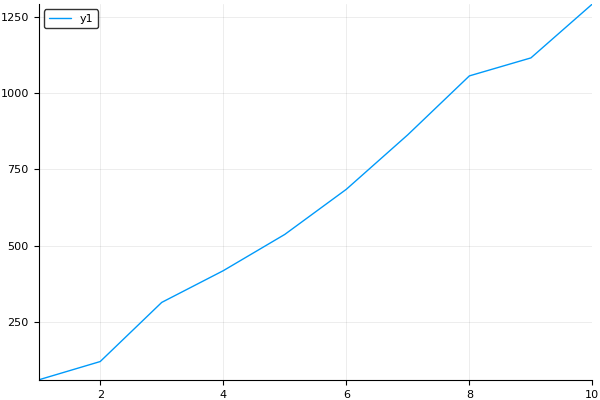

In [33]:
# Plot the trajectory
@manipulate for i = 1:10
plot(cumsum(x_train[:,i]))
end


In [34]:
hidden_layer_sizes = [20,10,1]
w1 = weights(hidden_layer_sizes)
x = [1 2 3 4 5 6 7 8 9 10]
predict(w1,x')

1×1 Array{Float64,2}:
 -0.00855506

Interact.Options{:SelectionSlider,Int64}(21: "input-6" = 5 Int64 , "i", 5, "5", 5, Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict(7=>"7",4=>"4",9=>"9",10=>"10",2=>"2",3=>"3",5=>"5",8=>"8",6=>"6",1=>"1"…)), Any[], Any[], true, "horizontal")


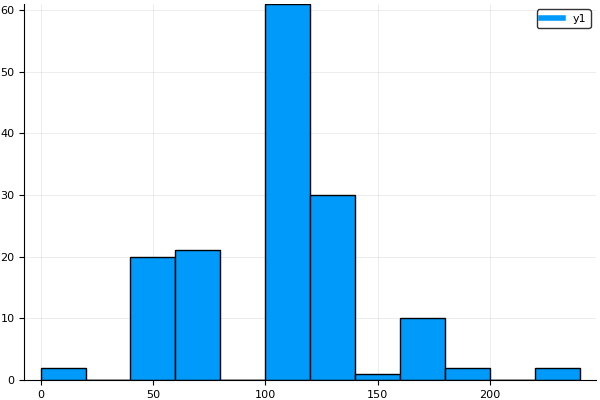

In [26]:
@manipulate for i = 1:10
histogram(x_train[i,:])
end


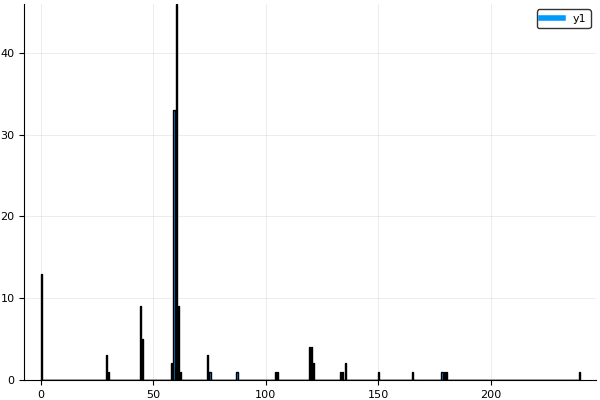

In [24]:
histogram(y_train')
# mean(y_train)
# sqrt(var(y_train))

In [ ]:
# https://arxiv.org/pdf/1407.5949.pdf
function lstm(weight,bias,hidden,cell,input)
    gates   = hcat(input,hidden) * weight .+ bias
    hsize   = size(hidden,2)
    forget  = sigm(gates[:,1:hsize])
    ingate  = sigm(gates[:,1+hsize:2hsize])
    outgate = sigm(gates[:,1+2hsize:3hsize])
    change  = tanh(gates[:,1+3hsize:end])
    cell    = cell .* forget + ingate .* change
    hidden  = outgate .* tanh(cell)
    return (hidden,cell)
end

function initmodel(atype, hidden, vocab, embed)
    init(d...)=atype(xavier(d...))
    
    bias(d...)=atype(zeros(d...))
    model = Array(Any, 2*length(hidden)+3)
    X = embed
    for k = 1:length(hidden)
        H = hidden[k]
        model[2k-1] = init(X+H, 4H)
        model[2k] = bias(1, 4H)
        model[2k][1:H] = 1 # forget gate bias = 1
        X = H
    end
    model[end-2] = init(vocab,embed)
    model[end-1] = init(hidden[end],vocab)
    model[end] = bias(1,vocab)
    return model
end

let blank = nothing; global initstate
function initstate(model, batch)
    nlayers = div(length(model)-3,2)
    state = Array(Any, 2*nlayers)
    for k = 1:nlayers
        bias = model[2k]
        hidden = div(length(bias),4)
        if typeof(blank)!=typeof(bias) || size(blank)!=(batch,hidden)
            blank = fill!(similar(bias, batch, hidden),0)
        end
        state[2k-1] = state[2k] = blank
    end
    return state
end
end

function predict(model, state, input; pdrop=0)
    nlayers = div(length(model)-3,2)
    newstate = similar(state)
    for k = 1:nlayers
        input = dropout(input, pdrop)
        
        (newstate[2k-1],newstate[2k]) = lstm(model[2k-1],model[2k],state[2k-1],state[2k],input)
        input = newstate[2k-1]
    end
    return input,newstate
end